# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.io import read_image

from tqdm import tqdm
import gc

In [2]:
%cd /Users/bsohith/Documents/Classwork/Semester-2/MLOps/ece-gy-9183-group19
%pwd

/Users/bsohith/Documents/Classwork/Semester-2/MLOps/ece-gy-9183-group19


'/Users/bsohith/Documents/Classwork/Semester-2/MLOps/ece-gy-9183-group19'

Image shape: torch.Size([1, 1024, 1024])


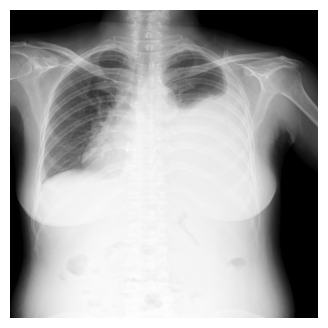

In [3]:
image = read_image("vinbigdata/train/0a0ac65c40a9ac441651e4bfbde03c4e.png")
print(f"Image shape: {image.shape}")

plt.figure(figsize=(4, 4))
plt.tight_layout()
plt.axis('off')
plt.imshow(image.permute(1, 2, 0), cmap='gray')

In [4]:
config = {
    'image_size': 320,
    'batch_size': 32,
    'precision': None,
    'accumulation_steps': 4,
    'model': 'faster-rcnn',

    'num_epochs': 1,
    'learning_rate': 1e-3,
    
    
}

In [5]:
import os
import torch
import cv2

from functools import lru_cache

class VinBigDataDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None, cache_size=256):

        self.img_dir = img_dir
        self.transform = transform

        # Read annotations once
        annotations = pd.read_csv(csv_file)
        annotations['class_id'] = annotations['class_id'].replace({0:14, 14:0})
        self.unique_images = annotations['image_id'].unique()

        self.annotations_dict = {}
        for img_id in self.unique_images:
            img_annotations = annotations[annotations['image_id'] == img_id]

            # Extract labels and class IDs once
            class_ids = img_annotations['class_id'].values
            label_names = img_annotations['class_name'].values

            # Store bounding boxes in normalized format to avoid recalculation
            boxes = []
            for _, row in img_annotations.iterrows():
                x_min, y_min = row['x_min'], row['y_min']
                x_max, y_max = row['x_max'], row['y_max']
                boxes.append([x_min, y_min, x_max, y_max])

            self.annotations_dict[img_id] = {
                'boxes': np.array(boxes, dtype=np.float32),
                'class_ids': np.array(class_ids, dtype=np.int64),
                'label_names': label_names
            }

        # Set up image cache
        self.image_cache = lru_cache(maxsize=cache_size)(self._load_image)
        self.image_dims = {}

    def _load_image(self, img_id):

        img_path = os.path.join(self.img_dir, f"{img_id}.png")
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            raise ValueError(f"Failed to load image: {img_path}")

        # Cache original dimensions for bbox scaling
        if img_id not in self.image_dims:
            self.image_dims[img_id] = (image.shape[0], image.shape[1])

        return image

    def __len__(self):
        return len(self.unique_images)

    def __getitem__(self, idx):
        img_id = self.unique_images[idx]

        # Get image from cache or load it
        image = self.image_cache(img_id)
        orig_height, orig_width = self.image_dims[img_id]

        # Resize once
        image = cv2.resize(image, (config['image_size'], config['image_size']))
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        image = torch.from_numpy(image.astype(np.float32) / 255.0).permute(2, 0, 1)

        # Get pre-processed annotations
        annotations = self.annotations_dict[img_id]
        boxes = annotations['boxes'].copy()

        # Scale bounding boxes in a vectorized operation
        if len(boxes) > 0:
            boxes[:, [0, 2]] = boxes[:, [0, 2]] / orig_width * config['image_size']
            boxes[:, [1, 3]] = boxes[:, [1, 3]] / orig_height * config['image_size']

        # Create target dictionary
        target = {
            'boxes': torch.as_tensor(boxes, dtype=torch.float32),
            'labels': torch.as_tensor(annotations['class_ids'], dtype=torch.int64),
            'image_id': torch.tensor([idx]),
            'label_names': annotations['label_names']
        }

        return image, target

# Models

In [6]:
import torchvision
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Load the pre-trained model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# Set the number of classes (14 objects + 1 background)
num_classes = 15

# Get the number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# Replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [7]:
def collate_fn(batch):
    images = []
    targets = []
    for image, target in batch:
        images.append(image)
        targets.append(target)
    return images, targets

In [8]:
def train_epoch(model, train_loader, optimizer, device, scaler=None):
    model.train()
    total_loss = 0.0

    progress_bar = tqdm(train_loader, desc="Training")

    # Track gradient accumulation
    optimizer.zero_grad(set_to_none=True)
    accumulated_steps = 0

    for idx, (images, targets) in enumerate(progress_bar):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v
                  for k, v in t.items()} for t in targets]

        # Forward pass 
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()

        # Gradient accumulation
        accumulated_steps += 1
        if accumulated_steps == config['accumulation_steps']:
            if config['precision'] == 'mixed':
                scaler.step(optimizer)
                scaler.update()
            else:
                optimizer.step()

            optimizer.zero_grad(set_to_none=True)
            accumulated_steps = 0

        # For reporting (use the original loss value)
        batch_loss = losses.item() * config['accumulation_steps']
        total_loss += batch_loss
        progress_bar.set_postfix(loss=batch_loss)

    # Handle any remaining gradients if dataset size is not divisible by accumulation steps
    if accumulated_steps > 0:
        if config['precision'] == 'mixed':
            scaler.step(optimizer)
            scaler.update()
        else:
            optimizer.step()
        optimizer.zero_grad(set_to_none=True)

    avg_loss = total_loss / len(train_loader)
    return avg_loss

In [9]:
def validate_epoch(model, val_loader, device):
    model.eval()
    total_loss = 0.0

    progress_bar = tqdm(val_loader, desc="Validation")

    with torch.no_grad():
        for images, targets in progress_bar:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v
                       for k, v in t.items()} for t in targets]

            # Forward pass
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            total_loss += losses.item()
            progress_bar.set_postfix(loss=losses.item())

    avg_loss = total_loss / len(val_loader)
    return avg_loss

In [10]:
def set_seed(seed=42):
    """Set all seeds for reproducibility"""
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

In [11]:
def main():
    set_seed()

    # Explicitly select CUDA device if available
    if torch.cuda.is_available():
        device = torch.device('cuda')
        torch.cuda.empty_cache()
        print(f"Using CUDA device: {torch.cuda.get_device_name(0)}")
    else:
        device = torch.device('cpu')
        print("CUDA not available, using CPU")

    # Create dataset
    csv_file = 'notebooks/data/scaled_bounding_boxes.csv'
    img_dir = 'vinbigdata/train'
    dataset = VinBigDataDataset(csv_file=csv_file, img_dir=img_dir)

    # Split dataset
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size

    # Use generator for reproducible splits
    generator = torch.Generator().manual_seed(42)
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=generator)

    # Optimize dataloader for GPU
    train_loader = DataLoader(
        train_dataset,
        batch_size=config['batch_size'],
        shuffle=True,
        collate_fn=collate_fn,
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=config['batch_size'] * 2,  # Can use larger batch size for validation
        shuffle=False,
        collate_fn=collate_fn,
    )

    # Create model
    if config['model'] == 'faster-rcnn':
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

        # Set the number of classes (14 objects + 1 background)
        num_classes = 15

        # Get the number of input features for the classifier
        in_features = model.roi_heads.box_predictor.cls_score.in_features

        # Replace the pre-trained head with a new one
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    else:
        raise ValueError("Invalid model name. Choose from 'faster-rcnn', 'retina-net' or 'ssd'.")

    model.to(device)

    # Use Adam with improvements from AdamW
    optimizer = torch.optim.AdamW(
        [
            {'params': list(model.backbone.parameters()), 'lr': config['learning_rate'] * 0.1},  # Lower LR for backbone
            {'params': list(model.rpn.parameters())},
            {'params': list(model.roi_heads.parameters())}
        ],
        lr=config['learning_rate'],
        weight_decay=0.01,
        amsgrad=True  # Helps with training stability
    )

    # Better learning rate scheduler with warmup
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=config['learning_rate'],
        epochs=config['num_epochs'],
        steps_per_epoch=len(train_loader) // config['accumulation_steps'],
        pct_start=0.1,  # Warmup for 10% of training
        div_factor=25,  # Initial LR is max_lr/25
        final_div_factor=1000,  # Final LR is max_lr/1000
    )

    # Mixed precision training setup
    scaler = None
    if config['precision'] == 'mixed' and device.type == 'cuda':
        scaler = torch.amp.GradScaler()

    history = {
        'train_loss': [],
        'val_loss': [],
    }

    # Training loop
    for epoch in range(config['num_epochs']):
        # Train
        train_loss = train_epoch(
            model,
            train_loader,
            optimizer,
            device,
            scaler
        )

        # Validate
        val_loss = validate_epoch(model, val_loader, device)

        # Log metrics
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)

        print(f'Epoch {epoch+1}/{config["num_epochs"]}:')
        print(f'  Train Loss: {train_loss:.4f}')
        print(f'  Val Loss: {val_loss:.4f}')

        # Save checkpoint
        if (epoch + 1) % 5 == 0 or epoch == config['num_epochs'] - 1:
            checkpoint_path = f"{config['model']}_checkpoint_epoch_{epoch+1}.pth"
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
                'config': config
            }, checkpoint_path)
            print(f"Checkpoint saved at epoch {epoch+1}: {checkpoint_path}")

    # Final model save
    final_model_path = f"{config['model']}_final.pth"
    torch.save(model.state_dict(), final_model_path)
    print(f"Training complete! Final model saved at: {final_model_path}")

    # Clean up GPU memory
    torch.cuda.empty_cache()
    gc.collect()

In [12]:
main()

CUDA not available, using CPU


Training:   0%|          | 1/375 [01:29<9:19:04, 89.69s/it, loss=nan]


KeyboardInterrupt: 